In [ ]:
import random
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import cv2

from matplotlib import pyplot as plt, image as img
from PIL import Image as PIL_image

from pathlib import Path
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)


In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

In [ ]:
dataset_directory = '/content/PetImages/'
# Directory with dog pictures
dogs_dataset_directory = os.path.join(dataset_directory, 'Dog')
cats_dataset_directory = os.path.join(dataset_directory, 'Cat')
dataset_full_dir = []
for pic in os.listdir(dogs_dataset_directory):
  if ".jpg" in pic:
    dataset_full_dir.append(os.path.join(dogs_dataset_directory, pic))

for pic in os.listdir(cats_dataset_directory):
  if ".jpg" in pic:
    dataset_full_dir.append(os.path.join(cats_dataset_directory, pic))

# shiffle dir list
random.shuffle(dataset_full_dir)

In [ ]:
# create folders
train_normal_dir = "/content/dataset/train/train_normal/"
train_upsidedown_dir = "/content/dataset/train/train_upsidedown/"
test_normal_dir = "/content/dataset/test/test_normal/"
test_upsidedown_dir = "/content/dataset/test/test_upsidedown/"
train_dir = "/content/dataset/train/"
test_dir = "/content/dataset/test/"

try: 
    # for auto classification train and tests
    os.mkdir('./dataset') 
    os.mkdir(train_dir) 
    os.mkdir(test_dir) 
    os.mkdir(train_normal_dir)
    os.mkdir(train_upsidedown_dir) 
    os.mkdir(test_normal_dir)
    os.mkdir(test_upsidedown_dir)
except OSError as error: 
    print(error)


In [ ]:
# move images to train and test folder - 80% train 20% test
train_num = int(len(dataset_full_dir) * 0.8)
test_num = int(len(dataset_full_dir) * 0.2)
for i, train in enumerate(dataset_full_dir[: train_num]):
  shutil.move(train, train_normal_dir + f"{i}.jpg")

for i, test in enumerate(dataset_full_dir[train_num: train_num + test_num]):
  shutil.move(test, test_normal_dir + f"{i}.jpg")
print(f"train: {train_num}  test: {test_num}")

train: 20000  test: 5000


The images need to rotate 180 degree because model should undrestand the normal image and rotation of it and compare between them.
https://deepai.org/publication/why-my-photos-look-sideways-or-upside-down-detecting-canonical-orientation-of-images-using-convolutional-neural-networks



In [ ]:
def rotate_180(src, dest):
  for dir in os.listdir(src):
      path = os.path.join(src, dir)
      img = cv2.imread(path)
      img = cv2.rotate(img,cv2.ROTATE_180)
      try:
        img_save = cv2.imwrite(dest + dir, img)
      except Exception as e:
        os.remove(path)

# call for train and test
rotate_180(train_normal_dir, train_upsidedown_dir)
rotate_180(test_normal_dir, test_upsidedown_dir)
print(len(os.listdir(train_normal_dir)))
print(len(os.listdir(test_normal_dir)))


In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 32
# based on MobileNet input
IMG_SHAPE = (224, 224)

# Flow training and test images in batches using train_datagen and test_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=batch_size, class_mode='binary', target_size=IMG_SHAPE, shuffle=True)
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=batch_size, class_mode='binary', target_size=IMG_SHAPE, shuffle=True)

Found 39902 images belonging to 2 classes.
Found 9990 images belonging to 2 classes.


Model MobileNet V2



In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
prediction_batch = prediction_layer(feature_batch_average)

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint("model.h5", save_best_only=True, verbose=1)

In [ ]:
history = model.fit(train_generator, validation_data = test_generator,
                    callbacks=[checkpoint, annealer],
                    steps_per_epoch= train_generator.samples // batch_size,
                    epochs=10)

Epoch 1/10
1060/1246 [========================>.....] - ETA: 27s - loss: 0.1938 - accuracy: 0.9236

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1246/1246 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9259
Epoch 1: val_loss improved from inf to 0.12870, saving model to model.h5
1246/1246 [==============================] - 239s 187ms/step - loss: 0.1890 - accuracy: 0.9259 - val_loss: 0.1287 - val_accuracy: 0.9504 - lr: 0.0100
Epoch 2/10
1246/1246 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9420
Epoch 2: val_loss did not improve from 0.12870
1246/1246 [==============================] - 232s 186ms/step - loss: 0.1556 - accuracy: 0.9420 - val_loss: 0.1369 - val_accuracy: 0.9512 - lr: 0.0100
Epoch 3/10
1246/1246 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9440
Epoch 3: val_loss improved from 0.12870 to 0.11596, saving model to model.h5
1246/1246 [==============================] - 228s 183ms/step - loss: 0.1558 - accuracy: 0.9440 - val_loss: 0.1160 - val_accuracy: 0.9566 - lr: 0.0100
Epoch 4/10
1246/1246 [==============================] - ETA: 0s - loss

In [ ]:
loss, accuracy = model.evaluate(test_generator)

313/313 [==============================] - 46s 147ms/step - loss: 0.1443 - accuracy: 0.9489


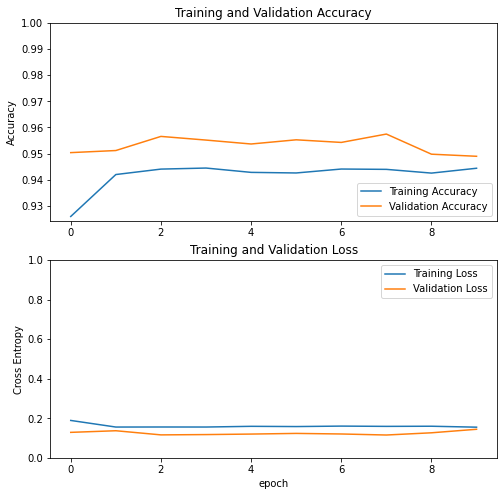

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

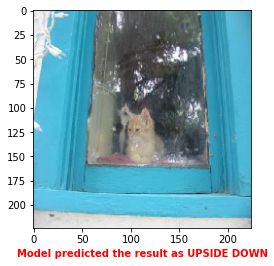

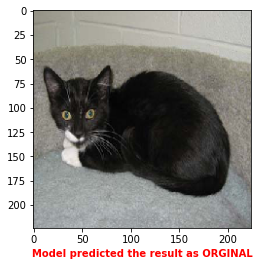

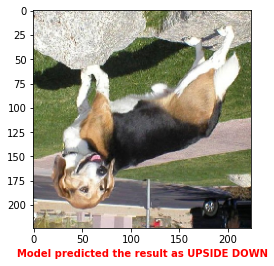

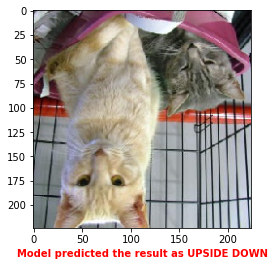

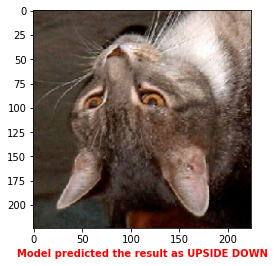

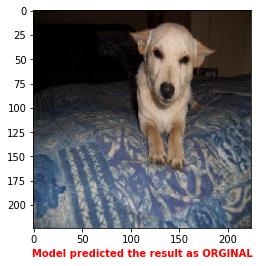

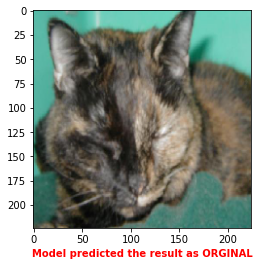

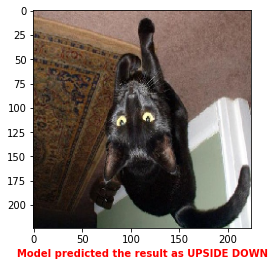

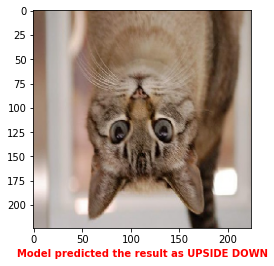

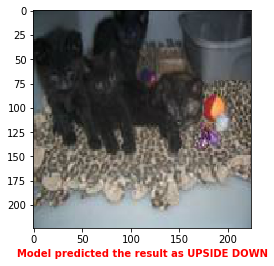

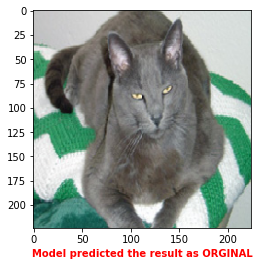

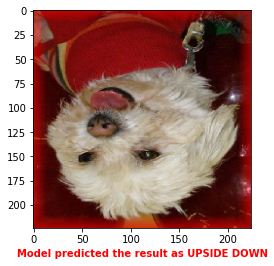

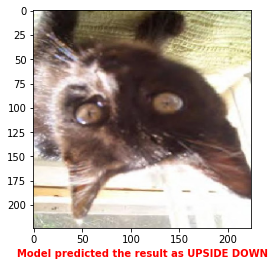

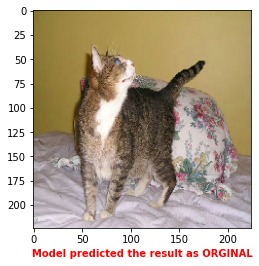

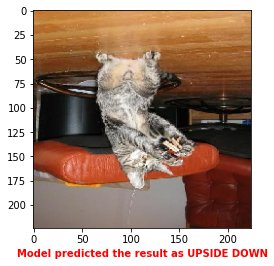

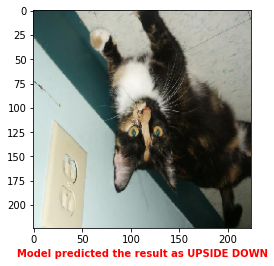

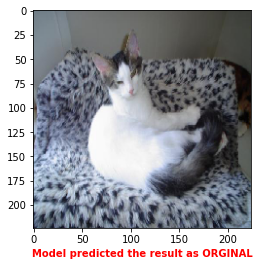

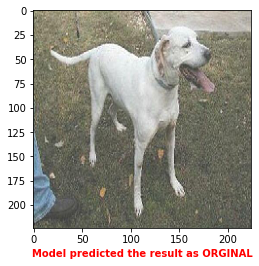

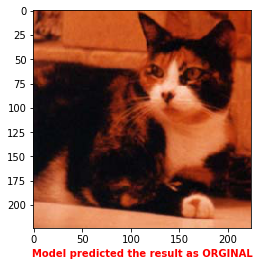

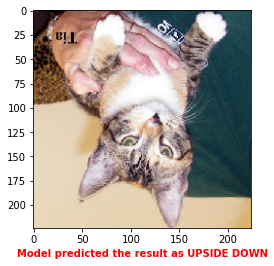

In [ ]:
# To print the final report
test_generator.reset()
j = 0
k = 0
for _ in range(20):
    # get first image of each batch

    # Report for orginal predicted cases
    X_train, y_train = test_generator.next()
    y_pred = model.predict(X_train)
    plt.imshow(X_train[0])
    # print(y_train[0])  
    # print(y_pred[0])
    prediction = "UPSIDE DOWN" if y_pred[0] > 0.5 else "ORGINAL"
    plt.xlabel(
        f"Model predicted the result as {prediction}",
        fontweight="bold",
        color="red"
    )

    plt.show()
    j = j + 1


hugging face model link:
https://huggingface.co/hosseinsho/upside_down_Fatima/resolve/main/upside_down.h5



# For improvement we should do these steps:


1.  **data augmentaion:** use upto 10 degree rotaion, zooming, shifts for images 

2.   **use more data:** using more data in different classes can help to undrestand the images and upside down of them.

3. **add some dense layers to pre-trained model:** The pre-trained model which I used was trained for different classes but need some dense layer with fully connected network.

4. **Hyperparamethers:** use different optimizer functions like RMSprob and change learning rates


As we can see in examples, wrong predicted images are also a little hard for human to recognize them. Environment's color of the images is somehow make the object disapear. Other wrong predicted images are almost same in their pixel values when they are upside down or not. So there is not difference between their orginal state or upside down.
 For solving them we need more data in these kind of distribution and data augmention can help.